# BAIT 508 Group Project — Health Services Sector Analysis

**Industry Focus:** Health Services (SIC Major Group 80)  \
**Deliverable Alignment:** Based on *BAIT508 Group Project – Public Firm Analysis (v3.0)*

This notebook preserves the optimized code while refreshing the markdown narrative so every project requirement (Parts 1A–3F) is clearly labeled.

## Environment Setup

The following cells install required resources and import the analysis stack used across the quantitative and NLP sections.

In [1]:
# download nltk
# Install all required libraries for Parts 1-3
%pip install pandas matplotlib nltk scikit-learn wordcloud gensim numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Core libraries for analysis and plotting
import pandas as pd  # tabulation
import matplotlib.pyplot as plt  # visualizations

import nltk
from nltk.corpus import stopwords
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import numpy as np
from gensim.models import Word2Vec
import ast
# Keep figures consistent with R aesthetic as we are familiar with it
plt.style.use('ggplot')

# Ensure NLTK stopwords are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohanjasani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Part 1 — Quantitative Analysis of the Health Services Sector (Major Group 80)

Deliverables 1A and 1B scope the Health Services sample from `public_firms.csv`, then answer the six descriptive questions specified in the project brief.

### Workflow Overview
- Filter firms whose SIC codes begin with 80 (Health Services).
- Compute Part 1A coverage metrics (unique firm-years, firms, continuous reporters).
- Address Part 1B prompts (Q1–Q6) on leaders, geography, trends, and the 2007→2008 shock.

In [3]:
# Load industry reference table and firm financials
major_groups = pd.read_csv('major_groups.csv')
public_firms = pd.read_csv('public_firms.csv')

# Health Services is major group code 80 in the reference list
sector_code = '80'
sector_info = major_groups.loc[major_groups['major_group'] == int(sector_code), 'description']
sector_name = sector_info.iloc[0] if not sector_info.empty else 'Unknown'

# Derive the two-digit major group prefix from each firm's SIC code
public_firms['major_group'] = (
    public_firms['sic']
    .fillna(0)            # replace missing SIC values before casting
    .astype(int)          # convert to integer (drops decimals)
    .astype(str)          # back to string for zero-padding
    .str.zfill(4)         # ensure four characters (e.g., 8011)
    .str.slice(0, 2)      # take the first two digits as the major group
)

# Filter the dataset to Health Services firms only
health_services = public_firms.loc[public_firms['major_group'] == sector_code].copy()
print(f"Sector selected: {sector_name} (code {sector_code})")
health_services[['gvkey', 'conm', 'fyear', 'sic']].head(10)  # preview the slice


Sector selected: Health Services (code 80)


,gvkey,conm,fyear,sic
1588,1431,AMERICAN CYTOGENETICS,1994,8071
1589,1431,AMERICAN CYTOGENETICS,1995,8071
2064,1559,AMERICAN SHARED HSPTL SERV,1995,8090
2065,1559,AMERICAN SHARED HSPTL SERV,1996,8090
2066,1559,AMERICAN SHARED HSPTL SERV,1997,8090
2067,1559,AMERICAN SHARED HSPTL SERV,1998,8090
2068,1559,AMERICAN SHARED HSPTL SERV,1999,8090
2069,1559,AMERICAN SHARED HSPTL SERV,2000,8090
2070,1559,AMERICAN SHARED HSPTL SERV,2001,8090
2071,1559,AMERICAN SHARED HSPTL SERV,2002,8090


### 1A — Industry Sector Selection and Data Filtering

Isolate Health Services firms, validate historical coverage, and highlight companies present in every fiscal year.

In [4]:
# Unique firm-year pairs underpin all Part 1A counts
firm_year_pairs = health_services[['gvkey', 'fyear']].drop_duplicates()
firm_year_count = firm_year_pairs.shape[0]

# Count distinct firms in the filtered sector
unique_firms = health_services['gvkey'].drop_duplicates().shape[0]

# Determine how many years each firm appears in the sample
distinct_years = health_services['fyear'].drop_duplicates().shape[0]
years_per_firm = (
    firm_year_pairs
    .groupby('gvkey')['fyear']
    .count()
)
full_span_firms = years_per_firm.loc[years_per_firm == distinct_years].index

# Collect headline metrics for Part 1A in a tidy table
summary_1a = pd.DataFrame({
    'metric': [
        'Unique firm-year observations',
        'Unique firms',
        f'Firms with records in all {distinct_years} years'
    ],
    'value': [
        firm_year_count,
        unique_firms,
        full_span_firms.shape[0]
    ]
})
summary_1a


,metric,value
0,Unique firm-year observations,3064
1,Unique firms,358
2,Firms with records in all 27 years,2


In [5]:
# List the firms that appear in every single fiscal year
full_span_details = (
    health_services[['gvkey', 'conm']]
    .drop_duplicates()
    .set_index('gvkey')
    .loc[full_span_firms]
    .sort_index()
)
full_span_details


,conm
gvkey,
7750,TENET HEALTHCARE CORP
61483,DAVITA INC


In [6]:
# Confirm the time range covered by the Health Services sample
time_span = pd.DataFrame({
    'min_year': [firm_year_pairs['fyear'].min()],
    'max_year': [firm_year_pairs['fyear'].max()],
    'distinct_years': [distinct_years]
})
time_span


,min_year,max_year,distinct_years
0,1994,2020,27


### 1B — Preliminary Analysis (Questions Q1–Q6)

Each subsection below maps directly to the six descriptive questions in the project brief.

#### Q1 — Highest Stock Prices in FY2020
Identify the ten Health Services firms with the largest closing price (`prcc_c`) in fiscal 2020.

In [7]:
# Part 1B Q1: top ten stock prices for fiscal 2020
top_prices_2020 = (
    health_services
    .loc[health_services['fyear'] == 2020, ['gvkey', 'conm', 'prcc_c']]
    .dropna(subset=['prcc_c'])
    .sort_values('prcc_c', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top_prices_2020


,gvkey,conm,prcc_c
0,2960,CHEMED CORP,532.61
1,30612,AMEDISYS INC,293.33
2,162404,LHC GROUP INC,213.32
3,14960,LABORATORY CP OF AMER HLDGS,203.55
4,24249,TELADOC HEALTH INC,199.96
5,22260,HCA HEALTHCARE INC,164.46
6,11032,UNIVERSAL HEALTH SVCS INC,137.50
7,25318,U S PHYSICAL THERAPY INC,120.25
8,64166,QUEST DIAGNOSTICS INC,119.17
9,61483,DAVITA INC,117.40


#### Q2 — Largest Sales Across the Sample
Rank firms by lifetime `sale` totals to pinpoint sustained revenue leaders.

In [8]:
# Part 1B Q2: strongest sales figures across the entire history
top_sales = (
    health_services[['gvkey', 'conm', 'fyear', 'sale']]
    .dropna(subset=['sale'])
    .sort_values('sale', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top_sales


,gvkey,conm,fyear,sale
0,22260,HCA HEALTHCARE INC,2020,51533.0
1,22260,HCA HEALTHCARE INC,2019,51336.0
2,22260,HCA HEALTHCARE INC,2018,46677.0
3,22260,HCA HEALTHCARE INC,2017,43614.0
4,22260,HCA HEALTHCARE INC,2016,41490.0
5,22260,HCA HEALTHCARE INC,2015,39678.0
6,22260,HCA HEALTHCARE INC,2014,36918.0
7,22260,HCA HEALTHCARE INC,2013,34182.0
8,22260,HCA HEALTHCARE INC,2012,33013.0
9,22260,HCA HEALTHCARE INC,2010,30683.0


#### Q3 — Headquarters Density
Summarize locations with the greatest concentration of distinct Health Services firms.

In [9]:
# Part 1B Q3: count distinct firms by headquarters location
location_firms = (
    health_services[['location', 'gvkey']]
    .fillna({'location': 'Unknown'})
    .drop_duplicates()  # prevent double-counting firms across years
)

location_counts = (
    location_firms
    .groupby('location')['gvkey']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='firm_count')
)
location_counts


,location,firm_count
0,USA,344
1,CAN,5
2,CHN,5
3,HKG,2
4,AUS,1
5,DEU,1


#### Q4 — Average Stock Price Trend (1994–2020)
Track the sector-wide average `prcc_c` to contextualize market performance over time.

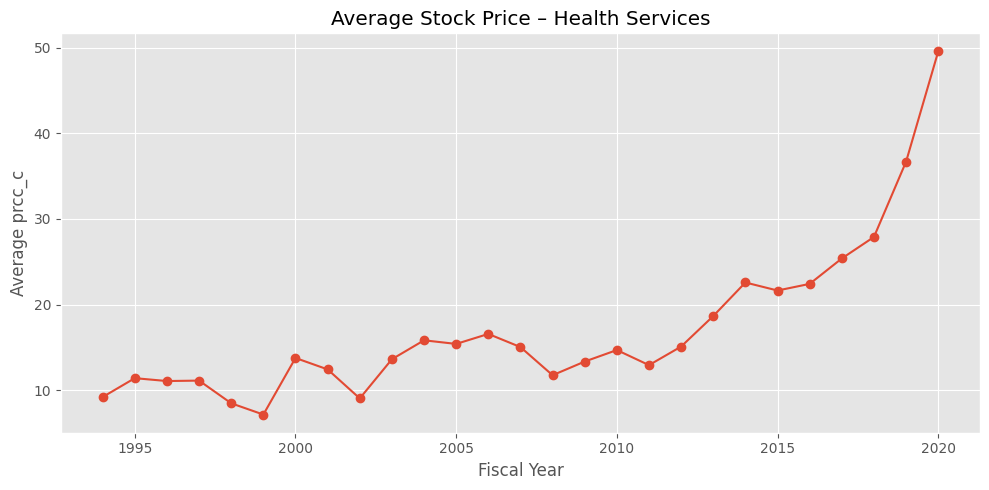

,fyear,average_prcc_c
0,1994,9.216750
1,1995,11.418145
2,1996,11.081550
3,1997,11.133215
4,1998,8.483696


In [10]:
# Part 1B Q4: average stock price trajectory for the sector
avg_price_by_year = (
    health_services
    .dropna(subset=['prcc_c'])
    .groupby('fyear')['prcc_c']
    .mean()
    .reset_index(name='average_prcc_c')
)

plt.figure(figsize=(10, 5))
plt.plot(avg_price_by_year['fyear'], avg_price_by_year['average_prcc_c'], marker='o')
plt.title('Average Stock Price – Health Services')
plt.xlabel('Fiscal Year')
plt.ylabel('Average prcc_c')
plt.tight_layout()
plt.show()

avg_price_by_year.head()  # preview the calculations


#### Q5 — 2008 Financial Crisis Impact
Measure the largest percentage drop in stock price between 2007 and 2008 to identify the most affected firm.

In [11]:
# Part 1B Q5: measure 2007→2008 stock-price drops during the crisis
# Slice 2007 prices, rename for clarity so both years coexist after merging
price_2007 = (
    health_services.loc[health_services['fyear'] == 2007, ['gvkey', 'prcc_c']]
    .rename(columns={'prcc_c': 'price_2007'})
)

# Slice 2008 prices with the same structure
price_2008 = (
    health_services.loc[health_services['fyear'] == 2008, ['gvkey', 'prcc_c']]
    .rename(columns={'prcc_c': 'price_2008'})
)

# Keep only firms that report prices in both years; discard zero baselines to avoid divide-by-zero
crisis_df = (
    price_2007
    .merge(price_2008, on='gvkey', how='inner')
    .query('price_2007 > 0')
)

# Compute the percentage drop relative to the 2007 price
crisis_df['drop_percentage'] = (
    (crisis_df['price_2007'] - crisis_df['price_2008'])
    / crisis_df['price_2007']
) * 100

# Rank by largest decline and keep the worst-hit firm
worst_hit = crisis_df.sort_values('drop_percentage', ascending=False).head(1)

# Attach the company name for reporting
worst_hit = worst_hit.merge(
    health_services[['gvkey', 'conm']].drop_duplicates(),
    on='gvkey',
    how='left'
)

# Show identifiers, prices, and the resulting percentage drop
worst_hit[['gvkey', 'conm', 'price_2007', 'price_2008', 'drop_percentage']]

,gvkey,conm,price_2007,price_2008,drop_percentage
0,149297,INSIGHT HEALTH SVCS HLDG CP,3.0,0.02,99.333333


#### Q6 — Average ROA Trend for U.S. Firms
Compute annual average ROA (`ni / at`) for U.S.-based firms to understand profitability resilience.

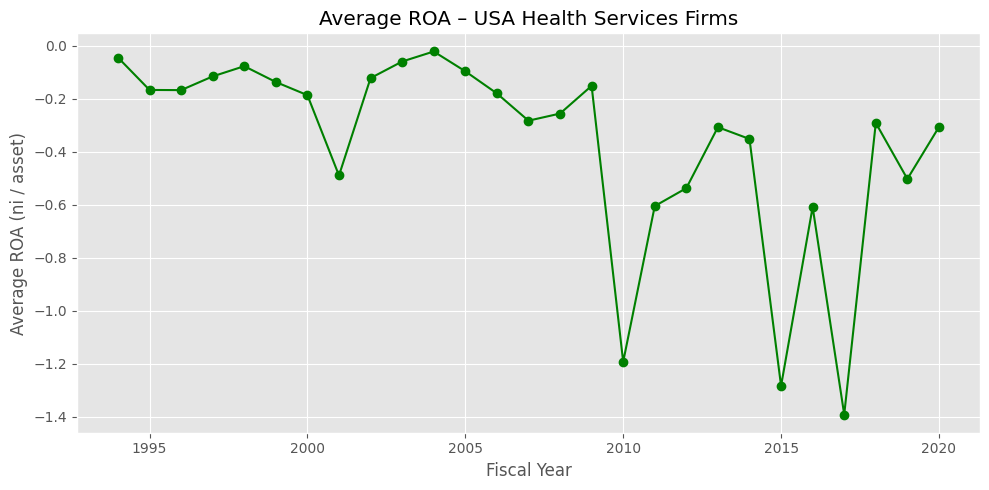

,fyear,average_roa
0,1994,-0.044346
1,1995,-0.166813
2,1996,-0.167436
3,1997,-0.115643
4,1998,-0.077044
5,1999,-0.136868
6,2000,-0.186443
7,2001,-0.489707
8,2002,-0.122032
9,2003,-0.059471


In [12]:
# Part 1B Q6: average ROA trend for USA-based firms
usa_roa_by_year = (
    health_services
    .loc[health_services['location'] == 'USA']
    .dropna(subset=['roa'])
    .groupby('fyear')['roa']
    .mean()
    .reset_index(name='average_roa')
)

plt.figure(figsize=(10, 5))
plt.plot(usa_roa_by_year['fyear'], usa_roa_by_year['average_roa'], marker='o', color='green')
plt.title('Average ROA – USA Health Services Firms')
plt.xlabel('Fiscal Year')
plt.ylabel('Average ROA (ni / asset)')
plt.tight_layout()
plt.show()

usa_roa_by_year.head(27)  # inspect the 27 years


### Part 1 Takeaways
- Health Services coverage spans 1994–2020 with two firms reporting every year.
- Outputs highlight price and revenue leaders, geographic concentration, market trajectory, crisis exposure, and profitability trends.

## Part 2 — Text Analysis of Health Services Narratives

Deliverables 2C–2E prepare Item 1 filings, extract firm-level keywords, and develop embeddings used in later strategy work.

### 2C — Text Cleaning Pipeline

Load the 2020 Item 1 sample, reuse the sector filters, and apply the optimized `clean_text` routine (lowercase, punctuation stripping, NLTK stop-word removal).

In [13]:
df = pd.read_csv('2020_10K_item1_full.csv')

In [14]:
df.head()

,cik,year,name,item_1_text,gvkey
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614
4,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614


In [15]:
# Reuse the major group lookup loaded earlier
major_grp = major_groups.copy()

In [16]:
required_sic = major_grp[major_grp['description'] == 'Health Services']['major_group'].values[0]

In [17]:
required_sic

80

In [18]:
# Reuse the public firms table loaded earlier
publ_grp = public_firms.copy()

In [19]:
# # referred from class notebooks  [Version 1 of function]
# def clean_text(x):
#     # convert string to lower case
#     x = x.lower()
#     # remove punctuation
#     translator = str.maketrans('', '', string.punctuation)
#     x = x.translate(translator)
#     # remove stopwords
#     clean_words = [w for w in x.split() if w not in stopwords.words('english')]
#     x = ' '.join(clean_words) # remove stopwords
#     return x

In [20]:
# Optimized clean_text function for faster execution [Version 2 of function]
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

def clean_text(x):
    x = x.lower()
    x = x.translate(translator)
    words = x.split()
    # Use list comprehension and set lookup for stopwords
    return ' '.join([w for w in words if w not in stop_words])

# Example usage:
# df['clean_item_1_text'] = df['item_1_text'].apply(clean_text)

In [21]:
df['clean_item_1_text'] = df['item_1_text'].apply(clean_text)

In [22]:
# Filter for rows where SIC code starts with '80' (healthcare services)
healthcare_companies = publ_grp[publ_grp['sic'].astype(str).str.startswith(str(required_sic))]

In [23]:
df

,cik,year,name,item_1_text,gvkey,clean_item_1_text
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119,fixed expenses previosuly documented 8k 235000...
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788,general hurco companies inc international indu...
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584,engaged business developing marketing products...
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun capital group formerly ...
4,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun capital group formerly ...
...,...,...,...,...,...,...
5476,740664,2020,R F INDUSTRIES LTD,"General RF Industries, Ltd. (together with sub...",2829,general rf industries ltd together subsidiarie...
5477,1074828,2020,"KNOW LABS, INC.","BACKGROUND AND CAPITAL STRUCTURE Know Labs, In...",166430,background capital structure know labs inc inc...
5478,40570,2020,GEE Group Inc.,"General GEE Group Inc. (the Company , us , ...",5050,general gee group inc company us incorporated ...
5479,1341726,2020,"GULFSLOPE ENERGY, INC.","General GulfSlope Energy, Inc. is an independe...",175595,general gulfslope energy inc independent crude...


### 2D — Keyword Analysis

Merge the cleaned filings with Health Services firms, derive top keywords via Counter and TF-IDF, and prepare visual summaries.

In [24]:
healthcare_companies = healthcare_companies.merge(df, on='gvkey', how='inner')

In [25]:
# Referred from Piazza
# collect top 10 key words using Counter
from collections import Counter
def get_top_keywords(sample_text):
    words = sample_text.split()
    c = Counter(words)
    lst = c.most_common(10)
    keywords = [] 
    for pair in lst:
        keywords.append(pair[0])
    return ' '.join(keywords)

In [26]:
healthcare_companies['top_10_keywords_counter'] = healthcare_companies['clean_item_1_text'].apply(get_top_keywords)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
# referred from class notebooks
def get_keywords_tfidf(document_list):
    '''
    This function gets a list of documents as input and returns a list of top 10 keywords for each document using TF-IDF scores.
    Input: A list of documents (text)
    Output: The corresponding top 10 keywords for each document based on tf-idf values
    '''
    vectorizer = TfidfVectorizer() # Step 1: Create a TF-IDF vectorizer
    tfidf_matrix = vectorizer.fit_transform(document_list) # Step 2: Calculate the TF-IDF matrix
    feature_names = vectorizer.get_feature_names_out() # Step 3: Get feature names (words)

    # Step 4: Extract top 10 keywords for each document
    top_keywords = [] # accumulator
    for i in range(len(document_list)):
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        feature_value = [tfidf_matrix[i, x] for x in feature_index]
        tfidf_scores = zip(feature_index, feature_value)
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))

        if i % 200 == 199:
            print(f'Processed {i+1}/{len(document_list)} documents.')
    
    return top_keywords

In [29]:
healthcare_companies['top_10_keywords_tfidf'] = get_keywords_tfidf(healthcare_companies['clean_item_1_text'].to_list())

Processed 200/1218 documents.
Processed 400/1218 documents.
Processed 600/1218 documents.
Processed 800/1218 documents.
Processed 1000/1218 documents.
Processed 1200/1218 documents.


In [30]:
# import relevant packages
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [31]:
# prepare text
text_counter = ' '.join(healthcare_companies['top_10_keywords_counter'].tolist())

In [32]:
# prepare text
text_tfidf = ' '.join(healthcare_companies['top_10_keywords_tfidf'].tolist())

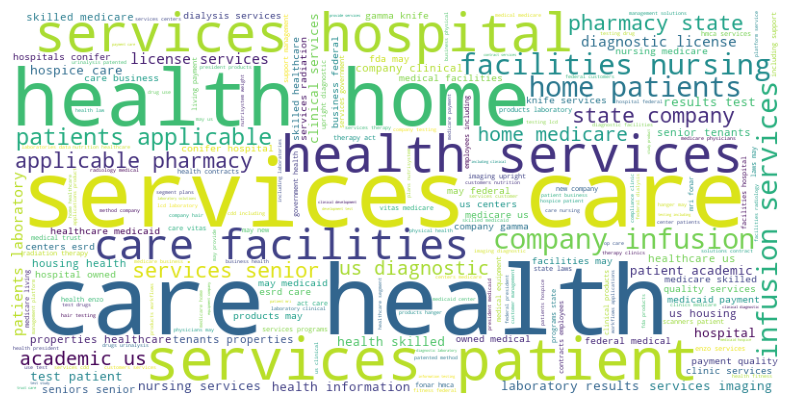

In [33]:
# wordcloud for counter
wordcloud1 = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(text_counter) 

plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(wordcloud1)
plt.savefig('keyword_all.png') # save as PNG file
plt.show()

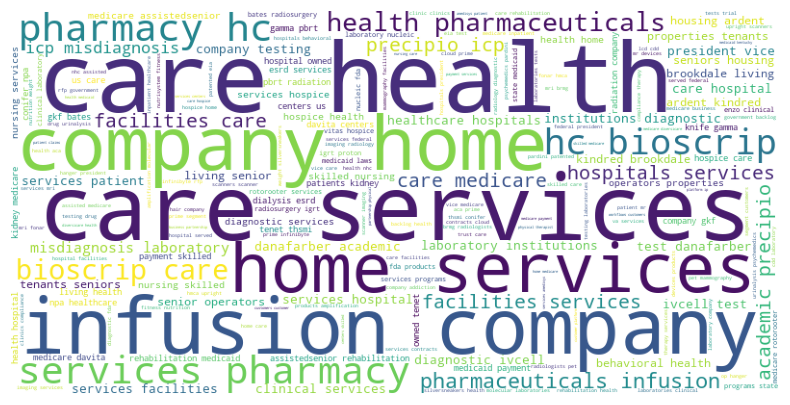

In [34]:
# wordcloud for tfidf
wordcloud2 = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(text_tfidf)
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(wordcloud2)
plt.savefig('keyword_all.png') # save as PNG file
plt.show()

### 2E — Word Embedding Exploration

Train Word2Vec embeddings on the cleaned corpus to support competitor similarity analysis.

#### 2E.1 — Train the Word2Vec Model

In [35]:
# Train a Word2Vec model on cleaned text
# Prepare sentences for Word2Vec (tokenized lists)
sentences = df['clean_item_1_text'].dropna().apply(lambda x: x.split()).tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1)  # sg=1 for skip-gram, 0 for CBOW

# Example: Get vector for a word
vector = w2v_model.wv['infusion','care','health']  # <-- Input words here
print(vector)

# Example: Find most similar words
similar_words = w2v_model.wv.most_similar(['infusion','care','health'], topn=5)  #Words assigned per previous section
print(similar_words)


[[ 0.065301    0.58983964  0.18991573  0.11790205  0.3218272  -0.3363126
  -0.20383875  0.65905905 -0.26903108  0.05817503  0.511188    0.20063913
  -0.18569714 -0.15851042 -0.22880112 -0.09466653 -0.6569163   0.09522127
  -0.0780031  -0.11901498  0.15413682 -0.22727016  0.46392837  0.6084618
   0.15063687 -0.15320669 -0.43563884 -0.58439845 -0.10690008 -0.3067676
   0.47879946 -0.84326285  0.10474993 -0.31401876  0.37976167  0.7623844
  -0.7471076   0.5347184  -0.27021083 -0.64806867 -0.12248557 -0.06732354
  -0.13453345 -0.08506587  0.24272317  0.10839815  0.24023981  0.35983887
   0.00513235  0.39424655 -0.26722476 -0.61132854 -0.39588657 -0.38725427
  -0.7472242  -0.24419191 -0.4529781  -0.08573042 -0.61924684  0.4727999
   0.6205932   0.4644437  -0.05491237  0.44450307  0.13347016 -0.06241619
  -0.10190931  0.20444514 -0.04481943 -0.01861591 -0.20670508  0.13397208
  -0.13880275 -1.093002    0.03809176  0.31700343 -0.5987139   0.31700307
  -0.26805446  0.10376813  0.22727077 -0.41

#### 2E.2 — Build Firm-Level Embeddings

In [36]:
# Create firm-level embeddings by summing word vectors for each firm's cleaned text
def get_firm_embedding(text, model):
    words = text.split()
    vectors = [model.wv[w] for w in words if w in model.wv]
    if vectors:
        return np.sum(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # fallback if no words in vocab

# Apply to each firm (row)
df['firm_embedding'] = df['clean_item_1_text'].apply(lambda x: get_firm_embedding(x, w2v_model))

# Example: firm_embedding for first row
print(df['firm_embedding'].iloc[0])

[ -26.731487      3.9498096    57.69895      16.334326     83.171486
 -116.33756      11.711937     84.66618       2.2630157    -5.4274855
   -7.3439746    20.130152    -73.094635     17.170725     31.687756
  -89.26575      -0.5462078   -74.58966      -5.0854063   -45.8939
   69.717186      4.7874904    38.95317     118.08547      -6.601607
  -32.99717      -7.099262     27.274586    -54.661137     21.577702
   44.715046    -72.669975    -30.124361    -44.099525     61.477985
   20.225796     -3.7541013   -81.73053     -59.881138    -67.947845
   30.50178     -10.839692   -128.83032     -14.099422      6.531042
    0.19985545   18.21221      80.15971      27.633635     92.44289
   -0.32907325  -19.419552    -35.835556      2.6556165   -24.394552
   31.294712     28.789064    -13.194832    -30.81486      37.42992
   19.179197     57.308315    -29.694286    -11.69483       9.858422
   26.82434     -34.07173      68.891         7.963869     50.79859
   65.63664       7.8662486    17.1976

### Part 2 Takeaways
- Cleaned narratives enable reproducible keyword rankings for Health Services firms.
- Counter vs. TF-IDF views highlight dominant telehealth and regulatory terminology.
- Word2Vec embeddings provide the quantitative bridge into the firm-level strategy work.

## Part 3 — Firm-Level Strategic Analysis

Deliverable 3F leverages the quantitative and textual insights to craft a recommendation for a focal Health Services firm.

### 3F — Firm Analysis and Strategy Roadmap

We concentrate on Teladoc Health (GVKEY 24249) to frame the competitive landscape before issuing a recommendation.

In [37]:
# Intial Step: Determine company to focus on
#   - Find company's market share, and sort by descending markt share, pick a company from the top 20

# Get health sector major group code
health_major_code = major_grp[major_grp['description'] == 'Health Services']['major_group'].values[0]

# Filter for health sector companies
health_companies = publ_grp[publ_grp['sic'].astype(str).str.startswith(str(health_major_code))].copy()

# Calculate market share column
health_companies['market_share'] = health_companies['prcc_c'] * health_companies['ch']

# Sort by market share descending
sorted_health_companies = health_companies.sort_values('market_share', ascending=False)

# Display relevant columns
sorted_health_companies[['conm', 'gvkey', 'sic', 'prcc_c', 'ch', 'market_share']].head(20)  # Top 20 by market share

# Company Selected = "TELADOC HEALTH INC", gvkey = 24249

,conm,gvkey,sic,prcc_c,ch,market_share
77060,HCA HEALTHCARE INC,22260,8062,164.46,1793.000,294876.78000
58187,LABORATORY CP OF AMER HLDGS,14960,8071,203.55,1320.800,268848.84000
41013,UNIVERSAL HEALTH SVCS INC,11032,8062,137.50,1224.490,168367.37500
82137,TELADOC HEALTH INC,24249,8090,199.96,733.324,146635.46704
135469,QUEST DIAGNOSTICS INC,64166,8071,119.17,1158.000,137998.86000
135468,QUEST DIAGNOSTICS INC,64166,8071,106.79,1192.000,127293.68000
121184,DAVITA INC,61483,8090,69.71,1499.116,104503.37636
27269,TENET HEALTHCARE CORP,7750,8062,39.93,2446.000,97668.78000
77059,HCA HEALTHCARE INC,22260,8062,147.81,621.000,91790.01000
58182,LABORATORY CP OF AMER HLDGS,14960,8071,123.64,716.400,88575.69600


#### 3F.1 — Identify Comparable Firms (Word2Vec Similarity)

Use the embeddings constructed in Part 2E to surface close narrative peers for Teladoc Health.

In [38]:
# Find companies with similar embeddings to the company whose gvkey = 24249
target_gvkey = "24249"  # as string, to match all types
target_row = df[df['gvkey'].astype(str) == target_gvkey]

if not target_row.empty:
    target_embedding = target_row['firm_embedding'].values[0]
    def cosine_similarity(a, b):
        from numpy.linalg import norm
        return np.dot(a, b) / (norm(a) * norm(b)) if norm(a) > 0 and norm(b) > 0 else 0
    df['similarity_to_target'] = df['firm_embedding'].apply(lambda x: cosine_similarity(x, target_embedding))
    similar_companies = df[df['gvkey'].astype(str) != target_gvkey].sort_values('similarity_to_target', ascending=False).head(5)
    print(similar_companies[['name', 'gvkey', 'similarity_to_target']])
else:
    print(f"gvkey {target_gvkey} not found in DataFrame.")

                           name   gvkey  similarity_to_target
1152               INSULET CORP  177227              1.000000
2989  Senseonics Holdings, Inc.   26636              0.995267
317         Synchrony Financial   20686              0.994572
316                  DEXCOM INC  162887              0.994572
1968         ICU MEDICAL INC/DE   25110              0.991957


#### 3F.2 — Benchmark the Competitive Set

Compare year coverage and financial performance for Teladoc and its nearest competitors.

In [39]:
# Use the public_firms dataset loaded at the beginning
# Get gvkeys of top 5 competitors and target
competitor_gvkeys = similar_companies['gvkey'].astype(str).tolist()
all_gvkeys = competitor_gvkeys + [target_gvkey]

# Filter public_firms for these gvkeys
filtered_firms = public_firms[public_firms['gvkey'].astype(str).isin(all_gvkeys)]

# Sort by year (assuming column is named 'year')
filtered_firms = filtered_firms.sort_values('fyear')

# Store filtered competitor and target firm data in a new DataFrame
competitor_firm_df = filtered_firms.reset_index(drop=True)

# Display the DataFrame
competitor_firm_df

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,major_group
0,25110,1995,USA,ICU MEDICAL INC,1992/03/31,3841,17.000,29.665,4.161,47.850,21.282,0.086959,38
1,25110,1996,USA,ICU MEDICAL INC,1992/03/31,3841,7.875,31.760,4.739,49.639,24.599,0.095469,38
2,25110,1997,USA,ICU MEDICAL INC,1992/03/31,3841,12.375,35.112,5.682,51.186,30.404,0.111007,38
3,25110,1998,USA,ICU MEDICAL INC,1992/03/31,3841,22.000,2.048,7.222,62.360,39.842,0.115811,38
4,25110,1999,USA,ICU MEDICAL INC,1992/03/31,3841,15.250,1.901,9.419,75.364,47.014,0.124980,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,25110,2020,USA,ICU MEDICAL INC,1992/03/31,3841,214.490,396.097,86.870,1763.691,1273.049,0.049255,38
80,24249,2020,USA,TELADOC HEALTH INC,2015/07/01,8090,199.960,733.324,-485.136,17755.281,1093.962,-0.027323,80
81,20686,2020,USA,SYNCHRONY FINANCIAL,NaN,6141,34.710,11524.000,NaN,95948.000,NaN,NaN,61
82,162887,2020,USA,DEXCOM INC,2005/04/14,3845,369.720,817.600,493.600,4290.500,1926.700,0.115045,38


In [40]:
# Show record count and year range for each company in competitor_firm_df
summary = competitor_firm_df.groupby('gvkey').agg(
    company_name=('conm', 'first'),
    record_count=('gvkey', 'size'),
    min_year=('fyear', 'min'),
    max_year=('fyear', 'max')
).reset_index()

print(summary)

    gvkey          company_name  record_count  min_year  max_year
0   20686   SYNCHRONY FINANCIAL             9      2012      2020
1   24249    TELADOC HEALTH INC             8      2013      2020
2   25110       ICU MEDICAL INC            26      1995      2020
3   26636  SENSEONICS HLDGS INC             7      2014      2020
4  162887            DEXCOM INC            18      2003      2020
5  177227          INSULET CORP            16      2005      2020


In [41]:
# Statsitcal Analysis = Create summary table: latest values and arithmetic average growth rates for ni, asset, sale per company (using competitor_firm_df)


def arithmetic_mean_growth_rate(series):
    series = series.dropna()
    if len(series) < 2:
        return np.nan
    growth_rates = []
    for i in range(1, len(series)):
        prev = series.iloc[i-1]
        curr = series.iloc[i]
        if prev == 0:
            growth = np.nan
        else:
            growth = (curr - prev) / abs(prev)
        growth_rates.append(growth)
    # Remove NaNs from growth_rates
    growth_rates = [g for g in growth_rates if not np.isnan(g)]
    if len(growth_rates) == 0:
        return np.nan
    return np.mean(growth_rates)

summary_table = []
for gvkey, group in competitor_firm_df.groupby('gvkey'):
    group_sorted = group.sort_values('fyear')
    latest_row = group_sorted.iloc[-1]
    min_year = group_sorted['fyear'].min()
    max_year = group_sorted['fyear'].max()
    ni_growth = arithmetic_mean_growth_rate(group_sorted['ni'])
    asset_growth = arithmetic_mean_growth_rate(group_sorted['asset'])
    sale_growth = arithmetic_mean_growth_rate(group_sorted['sale'])
    # Calculate market share for latest year
    market_share = latest_row['prcc_c'] * latest_row['ch']
    summary_table.append({
        'gvkey': gvkey,
        'company_name': latest_row['conm'],
        'latest_year': latest_row['fyear'],
        'latest_ni': latest_row['ni'],
        'latest_asset': latest_row['asset'],
        'latest_sale': latest_row['sale'],
        'min_year': min_year,
        'max_year': max_year,
        'avg_ni_growth_rate': ni_growth,
        'avg_asset_growth_rate': asset_growth,
        'avg_sale_growth_rate': sale_growth,
        'market_share': market_share
    })
summary_df = pd.DataFrame(summary_table)
# Format growth rates to percent with two decimals
for col in ['avg_ni_growth_rate', 'avg_asset_growth_rate', 'avg_sale_growth_rate']:
    summary_df[col] = (summary_df[col] * 100).map(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")
# Format currency columns to two decimals with $ sign
for col in ['latest_ni', 'latest_asset', 'latest_sale', 'market_share']:
    summary_df[col] = summary_df[col].map(lambda x: f"${x:,.2f}" if pd.notnull(x) else "")

# Show summary table for all 6 companies identified (formatted)
summary_df

,gvkey,company_name,latest_year,latest_ni,latest_asset,latest_sale,min_year,max_year,avg_ni_growth_rate,avg_asset_growth_rate,avg_sale_growth_rate,market_share
0,20686,SYNCHRONY FINANCIAL,2020,,"$95,948.00",,2012,2020,10.15%,8.05%,8.80%,"$399,998.04"
1,24249,TELADOC HEALTH INC,2020,$-485.14,"$17,755.28","$1,093.96",2013,2020,-125.55%,241.05%,79.18%,"$146,635.47"
2,25110,ICU MEDICAL INC,2020,$86.87,"$1,763.69","$1,273.05",1995,2020,30.49%,16.98%,23.81%,"$84,958.85"
3,26636,SENSEONICS HLDGS INC,2020,$-175.17,$35.92,$4.95,2014,2020,-45.56%,82.92%,545.18%,$15.70
4,162887,DEXCOM INC,2020,$493.60,"$4,290.50","$1,926.70",2003,2020,6.04%,43.69%,67.26%,"$302,283.07"
5,177227,INSULET CORP,2020,$6.80,"$1,872.90",$904.40,2005,2020,13.87%,47.95%,536.48%,"$231,907.54"


#### 3F.3 — Strategic Recommendation for Teladoc Health

Synthesize financial signals and textual themes to articulate an actionable strategy.

In [42]:
# Focused analysis on the target firm (TELADOC HEALTH INC, gvkey = 24249)
target_gvkey = 24249
target_firm_df = competitor_firm_df[competitor_firm_df['gvkey'] == target_gvkey].sort_values('fyear').copy()
target_firm_df.reset_index(drop=True, inplace=True)
target_firm_df  # Table of target firm data sorted by fyear

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,major_group
0,24249,2013,USA,TELADOC HEALTH INC,2015/07/01,8090,NaN,3.212,-6.019,27.386,19.906,-0.219784,80
1,24249,2014,USA,TELADOC HEALTH INC,2015/07/01,8090,NaN,46.436,-17.037,92.007,43.528,-0.185171,80
2,24249,2015,USA,TELADOC HEALTH INC,2015/07/01,8090,17.96,55.066,-58.020,229.737,77.384,-0.252550,80
3,24249,2016,USA,TELADOC HEALTH INC,2015/07/01,8090,16.50,50.015,-74.216,303.670,123.157,-0.244397,80
4,24249,2017,USA,TELADOC HEALTH INC,2015/07/01,8090,34.85,42.817,-106.782,824.391,233.279,-0.129528,80
5,24249,2018,USA,TELADOC HEALTH INC,2015/07/01,8090,49.57,423.989,-97.084,1528.876,417.907,-0.063500,80
6,24249,2019,USA,TELADOC HEALTH INC,2015/07/01,8090,83.72,514.353,-98.864,1602.827,553.307,-0.061681,80
7,24249,2020,USA,TELADOC HEALTH INC,2015/07/01,8090,199.96,733.324,-485.136,17755.281,1093.962,-0.027323,80


In [43]:
# Statistical Analysis: Z Score (shows what valeus are 'interesting' or 'noteworthy')
#
#  Table: Z-score (standard deviations from mean) for each column and year
cols_to_summarize = ['prcc_c', 'ch', 'ni', 'asset', 'sale', 'roa']
zscore_table = target_firm_df[['fyear']].copy()

for col in cols_to_summarize:
    mean = target_firm_df[col].mean()
    std = target_firm_df[col].std()
    # Calculate z-score for each year (value - mean) / std
    zscore_table[col + '_zscore'] = target_firm_df[col].apply(lambda x: (x - mean) / std if pd.notnull(x) and std > 0 else np.nan)

zscore_table  # Each row: year, z-score for each column

# Merge raw data table and z-score table for target firm by year
raw_data_table = target_firm_df[['fyear'] + cols_to_summarize].copy()
merged_table = pd.merge(raw_data_table, zscore_table, on='fyear', how='left')
merged_table  # Each row: year, raw values, and z-scores for each column

,fyear,prcc_c,ch,ni,asset,sale,roa,prcc_c_zscore,ch_zscore,ni_zscore,asset_zscore,sale_zscore,roa_zscore
0,2013,NaN,3.212,-6.019,27.386,19.906,-0.219784,NaN,-0.818477,0.730984,-0.455544,-0.822090,-0.800854
1,2014,NaN,46.436,-17.037,92.007,43.528,-0.185171,NaN,-0.664954,0.658994,-0.444910,-0.757444,-0.414738
2,2015,17.96,55.066,-58.020,229.737,77.384,-0.252550,-0.705507,-0.634302,0.391215,-0.422244,-0.664792,-1.166363
3,2016,16.50,50.015,-74.216,303.670,123.157,-0.244397,-0.726471,-0.652242,0.285392,-0.410077,-0.539526,-1.075418
4,2017,34.85,42.817,-106.782,824.391,233.279,-0.129528,-0.462983,-0.677808,0.072609,-0.324383,-0.238158,0.205963
5,2018,49.57,423.989,-97.084,1528.876,417.907,-0.063500,-0.251618,0.676043,0.135975,-0.208448,0.267108,0.942519
6,2019,83.72,514.353,-98.864,1602.827,553.307,-0.061681,0.238743,0.996999,0.124345,-0.196278,0.637653,0.962813
7,2020,199.96,733.324,-485.136,17755.281,1093.962,-0.027323,1.907836,1.774742,-2.399514,2.461886,2.117249,1.346078


### Part 3 Takeaways
- Embedding similarity highlights Teladoc’s closest narrative peers.
- Competitive benchmarking captures coverage windows, market share, and growth velocity.
- Z-score diagnostics pinpoint standout periods to anchor the strategic recommendation.

## Project Wrap-Up

- Part 1 quantified the Health Services landscape required for deliverables 1A–1B.
- Part 2 cleaned narratives, extracted keywords, and trained embeddings for deliverables 2C–2E.
- Part 3 combined embedding similarity and financial diagnostics to guide Teladoc Health's strategy.

## Generative AI Attribution

**Name, version, company of AI Tool:** Codex CLI (by OpenAI), Cursor Tab completion

**Chat Objective:**
You are a professional code reviewer. You will review my code, the data files and the attached pdf (questions for the group). I want you to come up with better ways to write/optimize my code. I will provide you with snippets and you will review them and come up with suggestions.

**Use of AI-generated content:**
The AI provided optimized code suggestions, best practices, and efficiency improvements for the function. The code and the functions were verified using https://pandas.pydata.org/docs/ for documentation.

**URL of chat history:** (Codex CLI cannot share chat history)

**Time and date of chat:** September 30, 2025

**Name, version, company of AI Tool:** ChatGPT, GPT-5, OpenAI

**Chat Objective:**
To review and optimize a Python `clean_text` function for performance and efficiency.

**Use of AI-generated content:**
The AI provided optimized code suggestions, best practices, and efficiency improvements for the function. The final run-time of the function was reduced to a few minutes from hours after implementing the suggestions from ChatGPT.

**URL of chat history:**
https://chatgpt.com/c/68dd73ec-eacc-8328-8b80-318216ea1ee1

**Time and date of chat:**
October 1, 2025, 11:34 AM

**Name, version, company of AI Tool:** Microsoft CoPilot in VS Studio, GPT-4.1

**Chat Objective:**
To assist with co-author the generation of the code for more complicated analysis and methods such as:
* Training a word2vec model
* Creating summation and statistical summary columns such as arithmetic/geometric averages, t-scores, z-scores

**Use of AI-generated content:**
The AI took my ideas and directions and provided code suggestions and which were further optimized when prompted. Outputs were verified against manual excel-based sample calculations for accuracy.

**URL of Chat History:** (Co-Pilot within Visual Studio cannot share chat history)

**Time and Dates of Chat(s):**
[September 30, 2025 7pm; October 1, 2025 8pm; October 2, 2025 8pm]
